In [1]:
import numpy as np
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt

np.random.seed(1123)

In [2]:
# Monte Carlo Simulation
dice_payoff = np.array([0.5, 1.05, 1.5])
dice_probs = np.array([1/6, 4/6, 1/6])
n_trials = 10_000
n_rolls = 300
mc = np.random.choice(dice_payoff, (n_trials, n_rolls), p=dice_probs)

In [3]:
arithmetic_mean = np.mean(mc, axis=1)
arithmetic_center  = np.mean(arithmetic_mean)
print(f"Arithmetic expected value: {arithmetic_center}")

geometric_mean = gmean(mc, axis=1)
geom_center  = gmean(geometric_mean)
print(f"Geometric expected value: {geom_center}")


Arithmetic expected value: 1.0332696
Geometric expected value: 0.9846144597539275


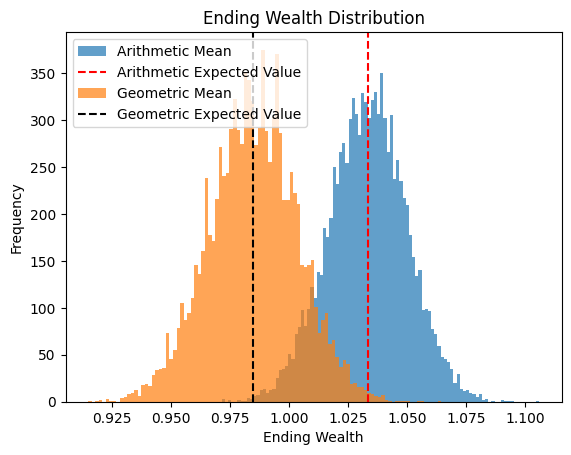

In [4]:
fig, ax = plt.subplots()
ax.hist(arithmetic_mean, bins=100, alpha=0.7, label='Arithmetic Mean')
plt.axvline(x=arithmetic_center, color='red', linestyle='--', label='Arithmetic Expected Value')
ax.hist(geometric_mean, bins=100, alpha=0.7, label='Geometric Mean')
plt.axvline(x=geom_center, color='black', linestyle='--', label='Geometric Expected Value')
ax.set_xlabel('Ending Wealth')
ax.set_ylabel('Frequency')
ax.set_title('Ending Wealth Distribution')
ax.plot()
ax.legend()

In [5]:
print(f"Expected $1 wealth after {n_rolls} rolls: ${geom_center**n_rolls:.2f} or a {(geom_center**n_rolls/1)**(1/n_rolls)-1:.2%} geometric compound growth rate")
print(f"Expected $1 wealth after {n_rolls} rolls: ${arithmetic_center**n_rolls:.2f} or a {(arithmetic_center**n_rolls/1)**(1/n_rolls)-1:.2%} arithmetic compound growth rate")

Expected $1 wealth after 300 rolls: $0.01 or a -1.54% geometric compound growth rate
Expected $1 wealth after 300 rolls: $18369.43 or a 3.33% arithmetic compound growth rate


## Kelly Criterion

In [6]:
# using a 40% bet and 60% cash
new_gmean = gmean(gmean(0.4*mc+0.6))
new_amean = np.mean(np.mean(0.4*mc+0.6))

print(f"Geometric CAGR: {(((new_gmean**n_rolls))/1)**(1/n_rolls)-1:.2%}")
print(f"Arithmetic CAGR: {((new_amean**n_rolls)/1)**(1/n_rolls)-1:.2%}")

Geometric CAGR: 0.64%
Arithmetic CAGR: 1.33%


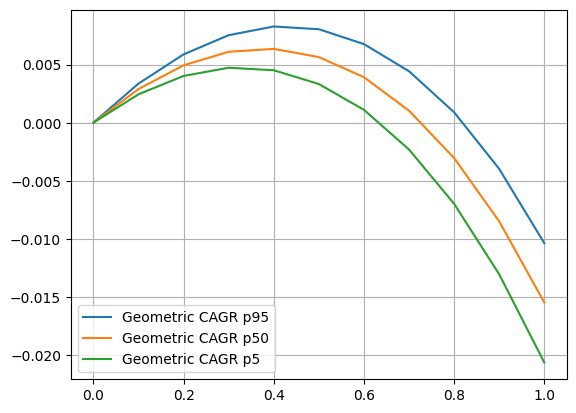

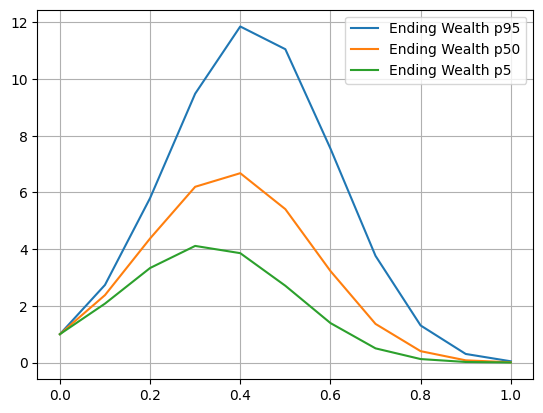

In [7]:
pct, ending_wealth_95, ending_wealth_50, ending_wealth_5, ending_wealth_mean = [], [], [], [], []
gmean_cagr_p95, gmean_cagr_p50, gmean_cagr_p5, gmean_cagr_mean = [], [], [], []

for pct_wager in np.arange(0, 1.1, 0.1):
    
    #p95
    gmean_p95 = np.percentile(gmean(pct_wager*mc+(1-pct_wager)), 95)
    gmean_cagr_p95.append((((gmean_p95**n_rolls))/1)**(1/n_rolls)-1)
    ending_wealth_95.append(gmean_p95**n_rolls)
    
    # p50
    gmean_p50 = np.percentile(gmean(pct_wager*mc+(1-pct_wager)), 50)
    gmean_cagr_p50.append((((gmean_p50**n_rolls))/1)**(1/n_rolls)-1)
    ending_wealth_50.append(gmean_p50**n_rolls)

    # Average
    gmean_mean = np.mean(gmean(pct_wager*mc+(1-pct_wager)))
    gmean_cagr_mean.append((((gmean_mean**n_rolls))/1)**(1/n_rolls)-1)
    ending_wealth_mean.append(gmean_mean**n_rolls)

    # p5
    gmean_p5 = np.percentile(gmean(pct_wager*mc+(1-pct_wager)), 5)
    gmean_cagr_p5.append((((gmean_p5**n_rolls))/1)**(1/n_rolls)-1)
    ending_wealth_5.append(gmean_p5**n_rolls)
    
    # x-axis
    pct.append(pct_wager)

fig, ax = plt.subplots()
ax.plot(pct, gmean_cagr_p95, label='Geometric CAGR p95')
ax.plot(pct, gmean_cagr_p50, label='Geometric CAGR p50')
ax.plot(pct, gmean_cagr_p5, label='Geometric CAGR p5')
ax.legend()
ax.grid()

fig, ax = plt.subplots()
ax.plot(pct, ending_wealth_95, label='Ending Wealth p95')
ax.plot(pct, ending_wealth_50, label='Ending Wealth p50')
ax.plot(pct, ending_wealth_5, label='Ending Wealth p5')
ax.legend()
ax.grid()

plt.show()

## Side Bets

In [12]:
insurance_payoff = np.array([11.0, -1.0, -1.0])
insurance_probs = np.array([1/6, 4/6, 1/6])
insured_pct = 0.09
n_rolls = 30

insurance_mc = np.random.choice(insurance_payoff, (n_trials, n_rolls), p=insurance_probs)

In [13]:
un_correlated_insurance_trials, correlated_insurance_trials = [], []
assert len(dice_payoff) == len(insurance_payoff)
for _ in range(n_trials):
     dice_choice = np.random.choice(np.arange(len(dice_payoff)), n_rolls, p=insurance_probs)
     insurance_choice = np.random.choice(np.arange(len(insurance_payoff)), n_rolls, p=insurance_probs)
     
     un_correlated_insurance_trial = np.array(
          (1-insured_pct)*dice_payoff[dice_choice]+
          insured_pct*insurance_payoff[insurance_choice]
     )
     
     correlated_insurance_trial = np.array(
          (1-insured_pct)*dice_payoff[dice_choice]+
          insured_pct*insurance_payoff[dice_choice]
     )

     correlated_insurance_trials.append(correlated_insurance_trial)
     un_correlated_insurance_trials.append(un_correlated_insurance_trial)

un_correlated_insurance_trials = np.array(un_correlated_insurance_trials)
correlated_insurance_trials = np.array(correlated_insurance_trials)

In [14]:
cor_gmean = np.median(gmean(correlated_insurance_trials, axis=1))
cor_amean = np.median(np.mean(correlated_insurance_trials, axis=1))

uncor_gmean = np.median(gmean(un_correlated_insurance_trials, axis=1))
uncor_amean = np.median(np.mean(un_correlated_insurance_trials, axis=1))

print(f"Correlated Insurance Geometric CAGR: {(((cor_gmean**n_rolls))/1)**(1/n_rolls)-1:.2%}")
print(f"Correlated Insurance Arithmetic CAGR: {(((cor_amean**n_rolls))/1)**(1/n_rolls)-1:.2%}")

print(f"Un-correlated Insurance Geometric CAGR: {(((uncor_gmean**n_rolls))/1)**(1/n_rolls)-1:.2%}")
print(f"Un-correlated Insurance Arithmetic CAGR: {(((uncor_amean**n_rolls))/1)**(1/n_rolls)-1:.2%}")

Correlated Insurance Geometric CAGR: 0.56%
Correlated Insurance Arithmetic CAGR: 3.03%
Un-correlated Insurance Geometric CAGR: -7.40%
Un-correlated Insurance Arithmetic CAGR: 2.80%


[]

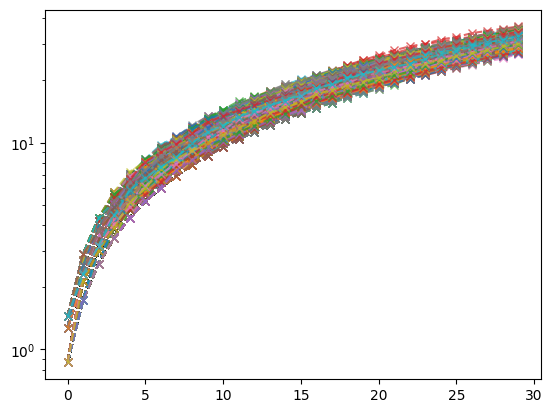

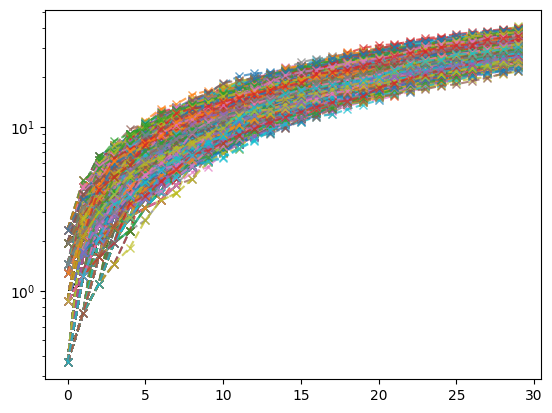

In [16]:
a = np.cumsum(correlated_insurance_trials, axis=1)
fig, ax = plt.subplots()
ax.plot(np.arange(n_rolls), a.T, alpha=0.7, marker = 'x', linestyle='--')
ax.set_yscale('log')
ax.plot()

a = np.cumsum(un_correlated_insurance_trials, axis=1)
fig, ax = plt.subplots()
ax.plot(np.arange(n_rolls), a.T, alpha=0.7, marker = 'x', linestyle='--')
ax.set_yscale('log')
ax.plot()

> TODO: model insurance_pct and payout_pct as a function of returns